In [1]:
import tensorflow as tf
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [2]:
import numpy as np
import tensorflow
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Activation,Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.applications import imagenet_utils
import h5py
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from sklearn.metrics import confusion_matrix
import itertools
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
test_path = "D:/Carpet1/test"
train_path = "D:/Carpet1/train"
valid_path = "D:/Carpet1/valid"

In [4]:
test_batches = ImageDataGenerator(preprocessing_function=keras.applications.mobilenet.preprocess_input).flow_from_directory(
    test_path, target_size=(224,224), batch_size=4, shuffle=False)
train_batches = ImageDataGenerator(preprocessing_function=keras.applications.mobilenet.preprocess_input).flow_from_directory(
    train_path, target_size=(224,224), batch_size=16)
valid_batches = ImageDataGenerator(preprocessing_function=keras.applications.mobilenet.preprocess_input).flow_from_directory(
    valid_path, target_size=(224,224), batch_size=4)

Found 145 images belonging to 2 classes.
Found 1601 images belonging to 2 classes.
Found 164 images belonging to 2 classes.


In [5]:
mobile = tf.keras.applications.mobilenet.MobileNet()


mobile.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                         

                                                                 
 conv_pw_8_bn (BatchNormaliz  (None, 14, 14, 512)      2048      
 ation)                                                          
                                                                 
 conv_pw_8_relu (ReLU)       (None, 14, 14, 512)       0         
                                                                 
 conv_dw_9 (DepthwiseConv2D)  (None, 14, 14, 512)      4608      
                                                                 
 conv_dw_9_bn (BatchNormaliz  (None, 14, 14, 512)      2048      
 ation)                                                          
                                                                 
 conv_dw_9_relu (ReLU)       (None, 14, 14, 512)       0         
                                                                 
 conv_pw_9 (Conv2D)          (None, 14, 14, 512)       262144    
                                                                 
 conv_pw_9

In [6]:
#Deleting the last 5 layers and replacing it with a dense softmax layer consisting of 2 nodes: Fire and Non-fire
x = mobile.layers[-2].output
predictions = Dense(2, activation='softmax')(x)
model = Model(inputs=mobile.input, outputs=predictions)

In [7]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                                      

                                                                 
 conv_pw_8_bn (BatchNormaliz  (None, 14, 14, 512)      2048      
 ation)                                                          
                                                                 
 conv_pw_8_relu (ReLU)       (None, 14, 14, 512)       0         
                                                                 
 conv_dw_9 (DepthwiseConv2D)  (None, 14, 14, 512)      4608      
                                                                 
 conv_dw_9_bn (BatchNormaliz  (None, 14, 14, 512)      2048      
 ation)                                                          
                                                                 
 conv_dw_9_relu (ReLU)       (None, 14, 14, 512)       0         
                                                                 
 conv_pw_9 (Conv2D)          (None, 14, 14, 512)       262144    
                                                                 
 conv_pw_9

In [8]:
#Freezing weights all the layers upto the 4th last layer
#This is done because we will retrain only the last three layers
for layer in model.layers[:-4]:
    layer.trainable = False

In [9]:
model.compile(Adam(learning_rate=.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [10]:
checkpoint=tf.keras.callbacks.ModelCheckpoint("D:/Carpet1/carpet_v1_final.h5",
                                             monitor='val_loss',mode="min",
                                             save_best_only=True)

In [11]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=1, min_lr=0.000001)

In [12]:
model.fit_generator(train_batches, steps_per_epoch = 27, validation_data=valid_batches, validation_steps=27, epochs=3, verbose=1, callbacks=[checkpoint,reduce_lr])

C:\Users\mamoo\AppData\Local\Temp\ipykernel_18204\1102617402.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(train_batches, steps_per_epoch = 27, validation_data=valid_batches, validation_steps=27, epochs=3, verbose=1, callbacks=[checkpoint,reduce_lr])


Epoch 1/3
27/27 [==============================] - 21s 230ms/step - loss: 1.2708 - accuracy: 0.7755 - val_loss: 0.8099 - val_accuracy: 0.8426 - lr: 0.0010
Epoch 2/3
27/27 [==============================] - 3s 105ms/step - loss: 0.6596 - accuracy: 0.8657 - val_loss: 0.8373 - val_accuracy: 0.7870 - lr: 0.0010
Epoch 3/3
27/27 [==============================] - 2s 92ms/step - loss: 0.2143 - accuracy: 0.9353 - val_loss: 1.0762 - val_accuracy: 0.7500 - lr: 1.0000e-04


In [13]:
test_labels = test_batches.classes
test_labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [14]:
test_batches.class_indices

{'Hand Made Fringes': 0, 'Machine Made Fringes': 1}

In [15]:
predictions = model.predict(test_batches, batch_size=2, verbose=1)

37/37 [==============================] - 7s 39ms/step


In [16]:
predictions

array([[1.28844202e-01, 8.71155739e-01],
       [5.79759926e-02, 9.42023993e-01],
       [8.78428280e-01, 1.21571675e-01],
       [2.84830034e-01, 7.15169966e-01],
       [2.12058201e-01, 7.87941813e-01],
       [9.97783482e-01, 2.21652677e-03],
       [1.13497768e-02, 9.88650203e-01],
       [1.11428779e-02, 9.88857090e-01],
       [9.66675818e-01, 3.33241969e-02],
       [9.78666782e-01, 2.13332474e-02],
       [9.90435600e-01, 9.56442486e-03],
       [9.99997854e-01, 2.11737074e-06],
       [9.99986172e-01, 1.38830010e-05],
       [9.99918938e-01, 8.11052669e-05],
       [9.99998450e-01, 1.53332701e-06],
       [9.99912262e-01, 8.77751154e-05],
       [9.99989152e-01, 1.08473223e-05],
       [9.99997616e-01, 2.41473208e-06],
       [9.99641418e-01, 3.58616933e-04],
       [9.80570495e-01, 1.94295105e-02],
       [9.99387741e-01, 6.12282951e-04],
       [9.99503374e-01, 4.96638240e-04],
       [9.77980793e-01, 2.20191479e-02],
       [9.92639184e-01, 7.36087002e-03],
       [9.999903

In [17]:
predictions.shape

(145, 2)

In [18]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [19]:
test_labels.shape

(145,)

In [20]:
cm = confusion_matrix(test_labels, predictions.argmax(axis =1))

In [21]:
test_batches.class_indices

{'Hand Made Fringes': 0, 'Machine Made Fringes': 1}

Confusion matrix, without normalization
[[49 19]
 [10 67]]


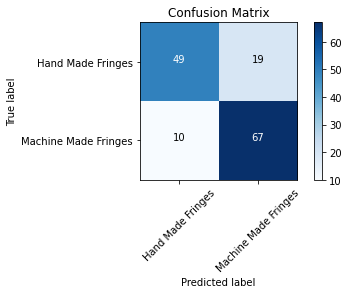

In [22]:
cm_plot_labels = ['Hand Made Fringes','Machine Made Fringes']
plot_confusion_matrix(cm ,cm_plot_labels, title='Confusion Matrix')